## Sequence Generation

### Setup

In [2]:
try:
    import google.colab
    IN_COLAB = True
    # %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    %pip install git+https://github.com/neelnanda-io/PySvelte.git
    renderer = "colab"
except:
    IN_COLAB = False
    from IPython import get_ipython
    %load_ext autoreload
    %autoreload 2
    renderer = "jupyterlab"

In [3]:
%%bash
cd ../
pip install poetry
poetry install
cd notebooks

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached urllib3-1.26.16-py2.py3-none-any.whl (143 kB)
  Using cached platformdirs-3.10.0-py3-none-any.whl (17 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.3
    Uninstalling urllib3-2.0.3:
      Successfully uninstalled urllib3-2.0.3
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 3.8.0
    Uninstalling platformdirs-3.8.0:
      Successfully uninstalled platformdirs-3.8.0
Installing dependencies from lock file

Package operations: 0 installs, 2 updates, 0 removals

  • Updating urllib3 (1.26.16 -> 2.0.3)
  • Updating platformdirs (3.10.0 -> 3.8.0)

Installing the current project: transformer-lens (0.0.0)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker 2.167.0 requires importlib-metadata<5.0,>=1.4.0, but you have importlib-metadata 5.2.0 which is incompatible.
sagemaker 2.167.0 requires protobuf<4.0,>=3.1, but you have protobuf 4.23.3 which is incompatible.
sparkmagic 0.20.5 requires nest-asyncio==1.5.5, but you have nest-asyncio 1.5.6 which is incompatible.


In [4]:

# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
pio.renderers.default = renderer


# Import stuff
import types
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import requests
import json

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
import ast
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.cm import ScalarMappable
import pickle
if IN_COLAB: 
    import pysvelte

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens.utilities import devices
from transformer_lens.past_key_value_caching import HookedTransformerKeyValueCache
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

In [8]:
import plotly.graph_objs as go

def plot_multiple_lines(y_values_list, x=None, line_names=None, title="", x_label="", y_label=""):
    traces = []
    
    if x is None: 
        x = np.arange(len(y_values_list[0]))
                             
    if line_names is None: 
        line_names = [f"Line {i}" for i in range(len(y_values_list))]
        
    for y_values, name in zip(y_values_list, line_names):
        trace = go.Scatter(x=x, y=y_values, name=name, visible=True)
        traces.append(trace)
    
    buttons = [
        {
            'args': [None, {'visible': [i == j for j in range(len(traces))]}],
            'label': name,
            'method': 'update'
        }
        for i, name in enumerate(line_names)
    ]
    
    buttons.append({
        'args': [None, {'visible': [True] * len(traces)}],
        'label': 'All',
        'method': 'update'
    })
    
    layout = go.Layout(
        title=title,
        xaxis={'title': x_label},
        yaxis={'title': y_label},
        showlegend=True,
        updatemenus=[{
            'buttons': buttons,
            'direction': 'down',
            'showactive': True,
            'x': 0.05,
            'xanchor': 'left',
            'y': 1.15,
            'yanchor': 'top'
        }]
    )
    
    fig = go.Figure(data=traces, layout=layout)
    fig.show()


def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)
def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

def cuda():
    return torch.cuda.is_available()

def get_device(): 
    return "cuda" if cuda() else "cpu"

def save_pickle(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

# Function to load a pickle object from a file
def load_pickle(filename):
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    return obj


device = get_device()
device

'cuda'

SEED = 42
torch.set_grad_enabled(False)## Model

In [9]:
SEED = 42
torch.set_grad_enabled(False)

In [10]:
# MODEL_NAME = "gpt2-large"
MODEL_NAME = "gpt2-large"

model = HookedTransformer.from_pretrained(
        MODEL_NAME,
        center_unembed=True,  
        center_writing_weights=True,              # Whether to center weights writing to the residual stream (ie set mean to be zero). Due to LayerNorm this doesn't change the computation.      
        fold_ln=True,                             # Whether to  fold in the LayerNorm weights to the subsequent linear layer.
        refactor_factored_attn_matrices=True,
    )

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-large into HookedTransformer


The model can do: 
- basic enumeration of numbers
- basic enumeration of letters
- double enumeration of numbers
- basic enumerate of powers of 2
- basic enumeration of squares 
- enumeration of evens and odds



The model cannot do: 
- Enumeration of primes
- Fibonacci sequence
- Enumeration of powers of 3
- more complicated arithmetic series

## Creating the dataset

In [11]:
def arithmetic_series(start, end, step): 
    p = [str(x) for x in range(start, end, step)]
    answer = p[-1]
    p = p[:-1]
    return " ".join(p), answer

def powers_of_two(start, n): 
    p = [str(2**x) for x in range(start, start+n)]
    answer = p[-1]
    p = p[:-1]
    return " ".join(p), answer

def squares(start, n): 
    p = [str(x**2) for x in range(start, start+n)]
    answer = p[-1]
    p = p[:-1]
    return " ".join(p), answer



In [12]:
import random

def sample_dataset(N, seed=None):
    if seed is not None:
        random.seed(seed)
    
    dataset = []
    
    while len(dataset) < N:
        func_choice = random.choice([arithmetic_series, powers_of_two, squares])
        
        if func_choice == arithmetic_series:
            start = random.randint(1, 100)
            step = random.randint(1, 5)
            end = min(start + (step * 10), 250)
            sequence, answer = arithmetic_series(start, end, step)
            
        elif func_choice == powers_of_two:
            start = random.randint(1, 10)
            n = 10
            sequence, answer = powers_of_two(start, n)
            
        else:  # func_choice == squares
            start = random.randint(1, 10)
            n = 10
            sequence, answer = squares(start, n)
            
        logits = model(sequence)
        mle = logits[:,-1,:].argmax(dim=-1)
        mle = model.to_string(mle)
        
        
        if mle.strip()==answer.strip(): 
            dataset.append((sequence, answer))
    
    return dataset


In [96]:
# dataset = sample_dataset(N=250)
# save_pickle(dataset, "data/sequence_dataset.pickle")

In [13]:
dataset = load_pickle("data/sequence_dataset.pickle")

Can we get any insight into how to model does addition and multiplication? Does the model use something periodic? Can the model do addition in other bases?

Tokens with lower indices usually correspond to more common words in the language, and the embeddings associated with these tokens are learned to capture their frequent patterns and meanings. As a result, during text generation, the model tends to assign higher probabilities to tokens with lower indices because they are more likely to appear in the context based on the patterns it has learned.

Here we see that the first 100 numbers, and the x50 and x00 numbers have lower token indices -> more likely by default in a bigram model. |


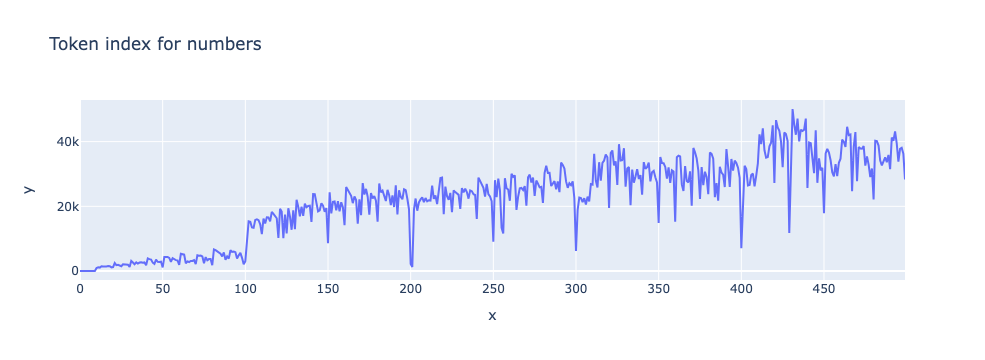

In [102]:
n = 500

single_token_numbers = torch.arange(n)
number_token_index = torch.tensor([model.to_single_token(str(i)) for i in range(n)])
line(number_token_index, title="Token index for numbers")

In [101]:
n = 100

single_token_numbers = torch.arange(n)
number_token_index = torch.tensor([model.to_single_token(str(i)) for i in range(n)])
line(number_token_index, title="Token index for numbers")

### We observe periodicity in the singular vectors

Matrix U (Left Singular Vectors):
It represents the rotation and scaling applied to the columnspace of the original matrix M. These vectors capture the directions in the original data space along which the data varies the most. The columns of matrix U represent the embeddings of words in the context of their usage or relationships within the corpus. Each column of U captures the "contextual meaning" of a word, indicating how the word relates to other words in terms of their co-occurrence patterns. U can be thought of as a matrix that transforms words from the vocabulary space to the contextual space, capturing the semantic relationships among words.

Matrix V (Right Singular Vectors):
Matrix V is also an orthogonal matrix, and it represents the rotation and scaling applied to the rowspace of the original matrix M. The columns of V (or rows of V^T) are often referred to as the right singular vectors. These vectors capture the directions in the feature (or attribute) space along which the data varies the most. The columns of matrix V (or rows of V^T) represent the embeddings of words in the original feature space (vocabulary space).
Each column of V captures the "intrinsic meaning" of a word, indicating its inherent properties or characteristics.
V can be thought of as a matrix that transforms words from the contextual space back to the original vocabulary space.



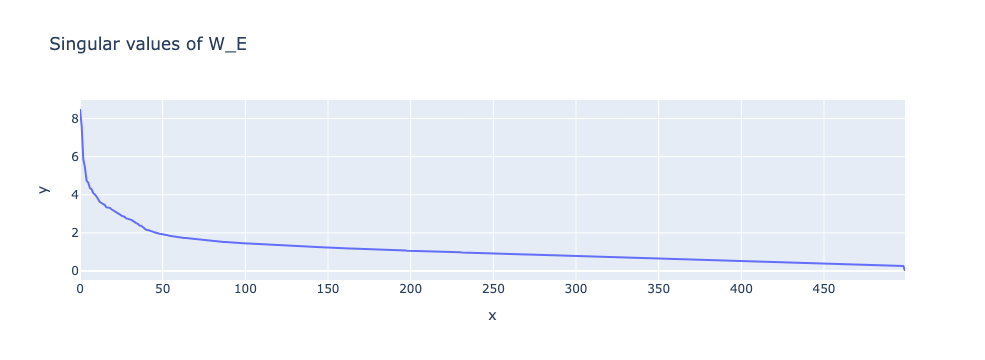

In [144]:
# We get the embeddings for the numbers we are interested in. We center the embeddings.
# We then to SVD on these centered embeddings. 

number_embeddings = model.W_E[number_token_index].float().to("cpu")
i_am_a_number = number_embeddings.mean(0)
number_embeddings_centered = number_embeddings - i_am_a_number
U, S, Vh = number_embeddings_centered.svd()
line(S, title="Singular values of W_E")

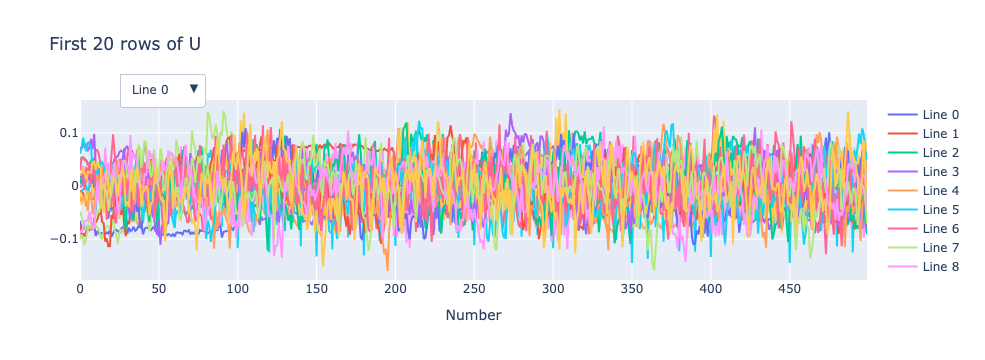

In [145]:
plot_multiple_lines(U[:, :20].T, title="First 20 rows of U", x_label="Number")


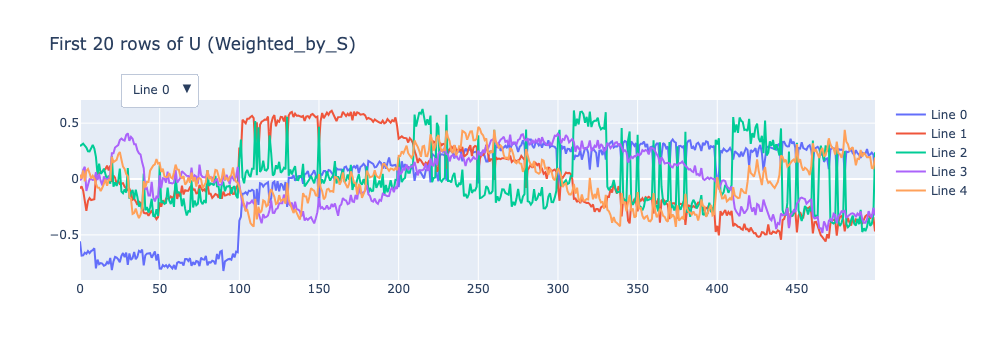

In [146]:
plot_multiple_lines((U[:, :5].T) * S[:5, None], title="First 20 rows of U (Weighted_by_S)")

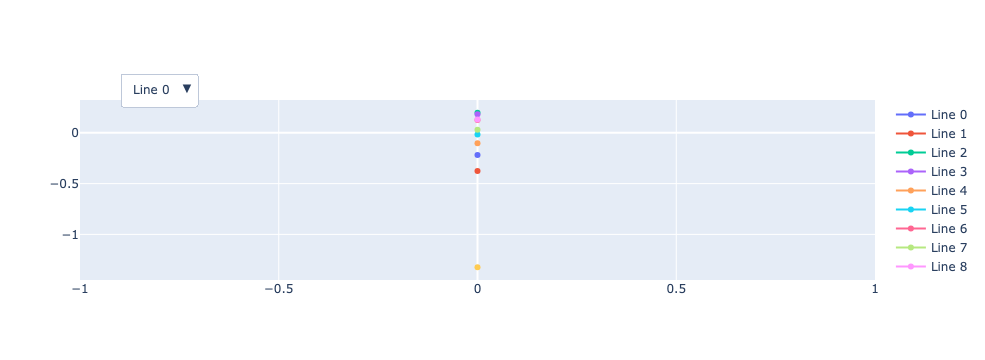

In [147]:
by_digit = einops.rearrange(number_embeddings_centered, "(other ten) d_model -> other ten d_model", ten=10)
U2, S2, Vh2 = by_digit.mean(0).svd()
line(S2)
plot_multiple_lines(U2.T)
plot_multiple_lines(U2.T @ S2[:, None])

# Periodicity within sequences

A little bit of periodicity. More periodicity for certain sequences. sample = ('5 10 15 25 30 35 40 50', '55')
prompt = sample[0].split(" ")
plot_periodicity(prompt)

In [184]:
def plot_periodicity(prompt, top_n=5): 
    prompt_tokens = torch.tensor([model.to_single_token(t) for t in prompt])
    sequence_embeddings = model.W_E[prompt_tokens].float().to("cpu")
    i_am_a_number = sequence_embeddings.mean(0)
    sequence_embeddings_centered = sequence_embeddings - i_am_a_number
    U, S, Vh = sequence_embeddings_centered.svd()
    plot_multiple_lines((U[:, :top_n].T) * S[:top_n, None], x=prompt, title=f"First {top_n} rows of U (Weighted_by_S)")
    

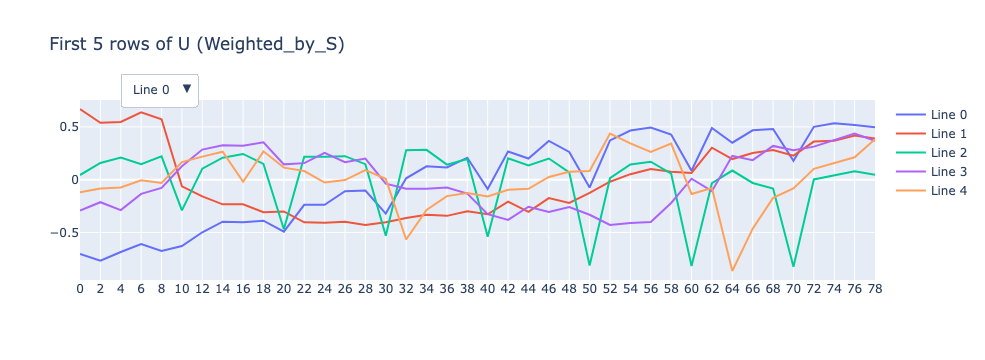

In [185]:
prompt = [str(x*2) for x in range(40)]
plot_periodicity(prompt)

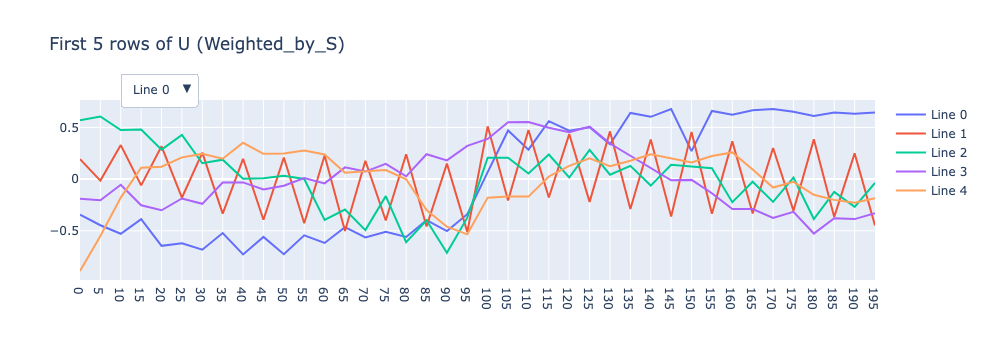

In [186]:
prompt = [str(x*5) for x in range(40)]
plot_periodicity(prompt)

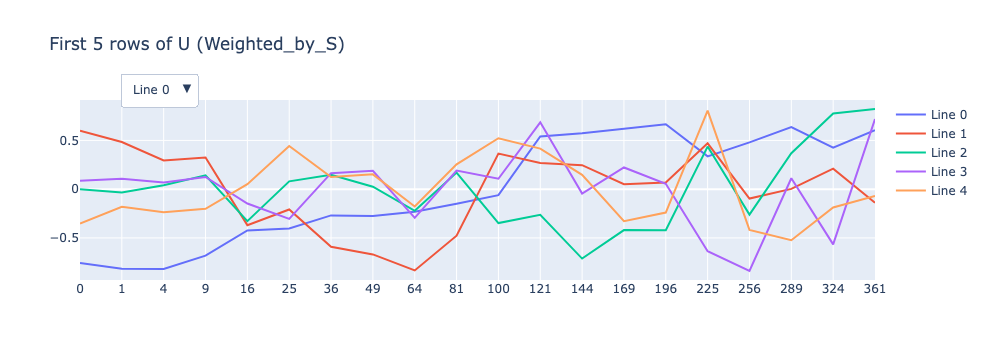

In [190]:
prompt = [str(x**2) for x in range(20)]
plot_periodicity(prompt)

In [191]:
def fourier_basis(n):
    terms = []
    labels = []
    terms.append(torch.ones(n))
    labels.append("const")
    for i in range(1, n//2):
        terms.append(torch.cos(torch.arange(n) * 2 * torch.pi / n * i))
        terms.append(torch.sin(torch.arange(n) * 2 * torch.pi / n * i))
        labels.append(f"cos_{i}")
        labels.append(f"sin_{i}")
    if n%2 == 0:
        terms.append(torch.tensor([(1 if j%2==0 else -1) for j in range(n)]))
        labels.append(f"sign")
    terms = torch.stack(terms)
    terms = terms / terms.norm(dim=-1, keepdim=True)
    return terms, labels

def plot_fourier_basis(token_index):
    number_embeddings = model.W_E[token_index].float().to("cpu")
    i_am_a_number = number_embeddings.mean(0)
    number_embeddings_centered = number_embeddings - i_am_a_number
    by_digit = einops.rearrange(number_embeddings_centered, "(other ten) d_model -> other ten d_model", ten=10)
    U2, S2, Vh2 = by_digit.mean(0).svd()


    fourier_terms, fourier_labels = fourier_basis(10)
    imshow(fourier_terms @ fourier_terms.T, title="Pairwise dot product (should be orthogonal)")
    imshow(fourier_terms @ U2, y=fourier_labels, labels={"x":"Singular Vectors", "y":"Fourier Terms"}, title="Singular Vectors of digit average in the Fourier basis")
    # imshow(fourier_terms.T @ U2)
    plot_multiple_lines(U2.T, title="Singular Vectors of by digit")
    


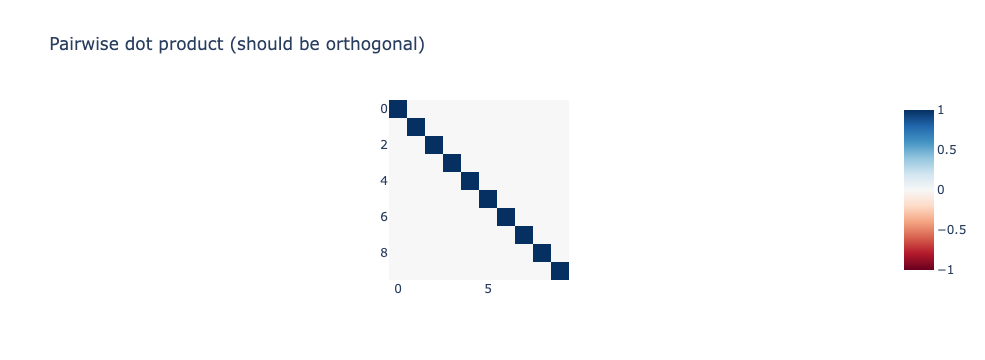

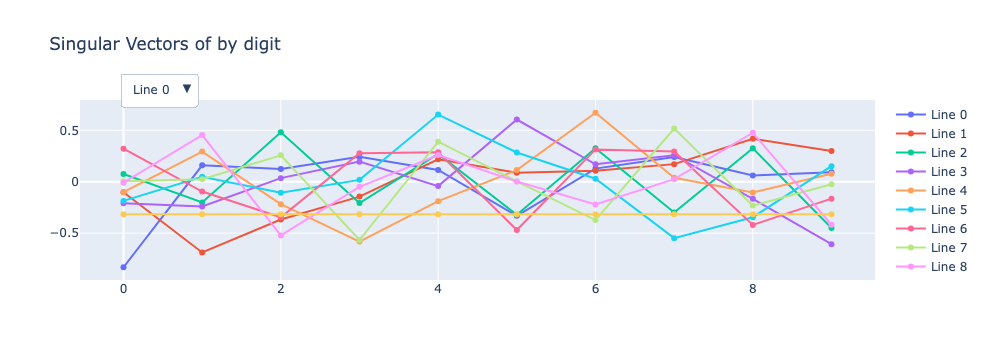

In [192]:
plot_fourier_basis(number_token_index)

In [196]:
prompt = [str(p*5) for p in range(40)]
prompt_tokens = torch.tensor([model.to_single_token(t) for t in prompt])

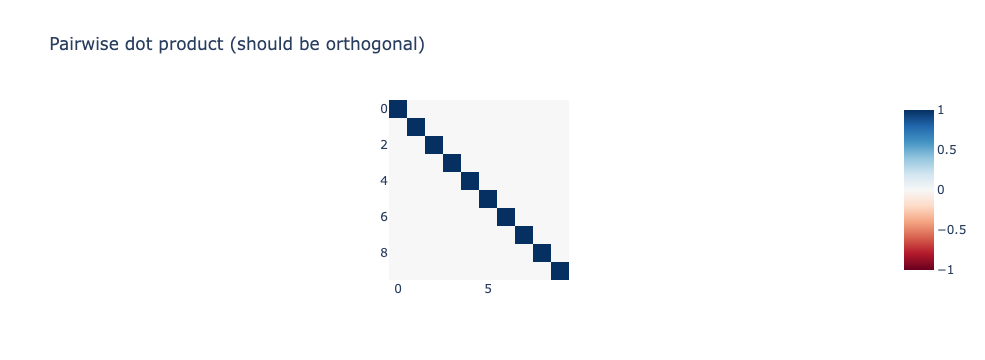

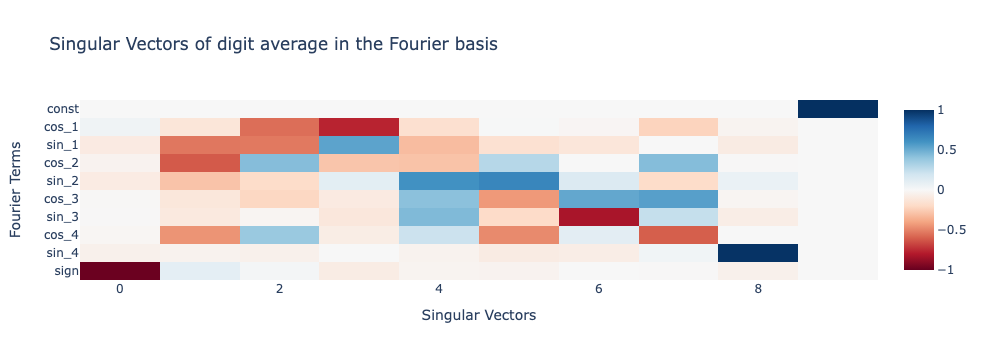

In [197]:
plot_fourier_basis(prompt_tokens)

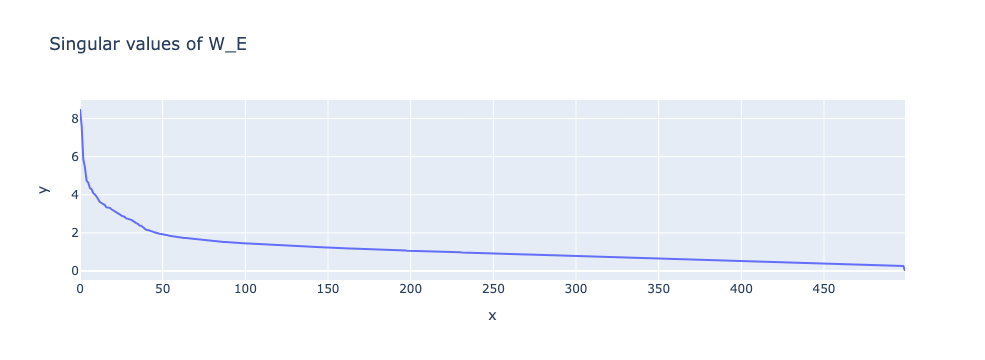

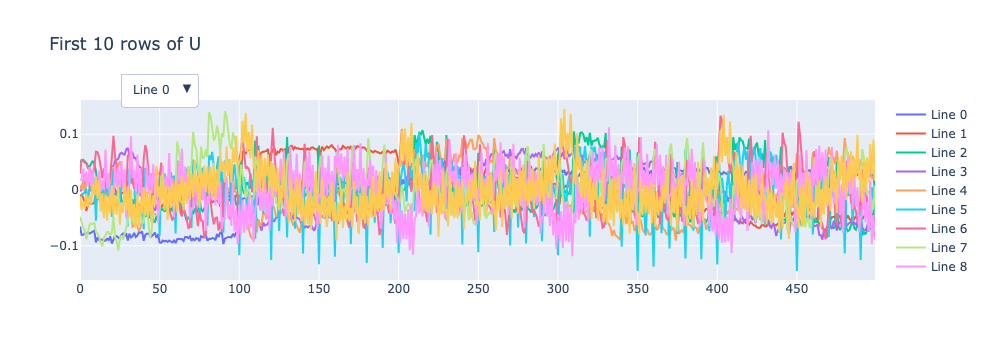

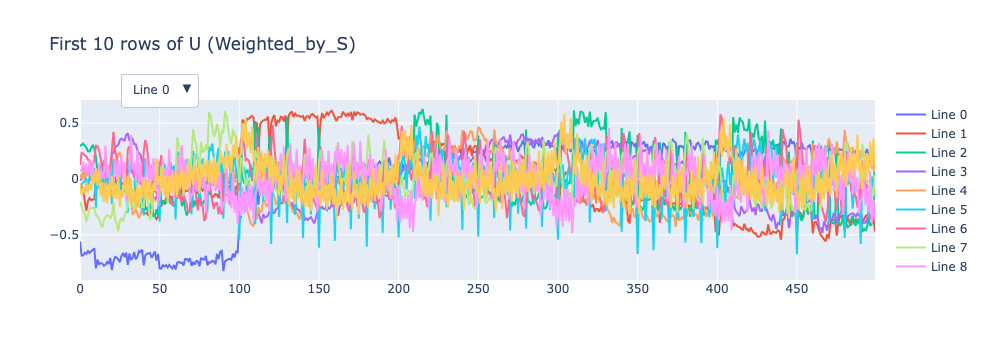

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x500 and 420x420)

In [202]:


U, S, Vh = number_embeddings_centered.svd()
line(S, title="Singular values of W_E")
plot_multiple_lines(U[:, :10].T, title="First 10 rows of U")
plot_multiple_lines((U[:, :10].T) * S[:10, None], title="First 10 rows of U (Weighted_by_S)")
fourier_terms_420, fourier_labels_420 = fourier_basis(420)
plot_multiple_lines((U[:, :10].T @ fourier_terms_420) * S[:10, None], title="Top 10 singular vectors in Fourier Space (420)", x=fourier_labels_420, x_label="Fourier Component")

fourier_terms_100, fourier_labels_100 = fourier_basis(100)
U100, S100, Vh100 = number_embeddings_centered[:100].svd()
plot_multiple_lines((U100[:, :10].T @ fourier_terms_100) * S[:10, None], title="Top 10 singular vectors in Fourier Space (100)", x=fourier_labels_100, x_label="Fourier Component")

In [203]:
line((fourier_terms_100 @ number_embeddings_centered[:100]).norm(dim=-1), x=fourier_labels_100, title="Norm of each Fourier Component (100 to 200)")
fourier_terms_400, fourier_labels_400 = fourier_basis(400)

line((fourier_terms_400 @ number_embeddings_centered[:400]).norm(dim=-1), x=fourier_labels_400, title="Norm of each Fourier Component (100 to 500)")

NameError: name 'fourier_terms_100' is not defined

In [14]:
full_prompts = [d[0] + " " + d[1] for d in dataset]
prompts = [d[0] for d in dataset]
answers = [d[1] for d in dataset]

In [15]:
num_prompts = 10

tokens = model.to_tokens(full_prompts)
logits, cache = model.run_with_cache(tokens)
log_probs = logits.log_softmax(dim=-1)
answer_tokens = torch.tensor([model.to_single_token(a) for a in answers]).to(device)
plps = (log_probs[torch.arange(num_prompts).to(device), -1, answer_tokens])
scatter(y=plps, x=prompts)

is_top_answer = (log_probs[:, -1, :].argmax(dim=-1) == answer_tokens)
scatter(x=is_top_answer, y=plps, title="Is top answer vs. log prob of top answer", yaxis="correct log prob", xaxis="is top answer")


OutOfMemoryError: CUDA out of memory. Tried to allocate 54.00 MiB (GPU 0; 14.75 GiB total capacity; 7.64 GiB already allocated; 38.81 MiB free; 8.85 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [30]:
num_prompts = 10


num_shot = 2
full_prompts, prompts, answers, x, y, z = make_n_shot_prompt(
    num_prompts, num_shot, 
    range_nums=(100, 200), 
    task="addition")

tokens = model.to_tokens(full_prompts)
logits, cache = model.run_with_cache(tokens)
log_probs = logits.log_softmax(dim=-1)
answer_tokens = torch.tensor([model.to_single_token(a) for a in answers]).to(device)
plps = (log_probs[torch.arange(num_prompts).to(device), -1, answer_tokens])
line(plps, x=prompts)

is_top_answer = (log_probs[:, -1, :].argmax(dim=-1) == answer_tokens)
scatter(x=is_top_answer, y=plps, title="Is top answer vs. log prob of top answer", yaxis="correct log prob", xaxis="is top answer")


In [32]:
filter = is_top_answer & (plps > -0.7)
print(filter.sum())
# %%
full_prompts_filt = [i for c, i in enumerate(full_prompts) if filter[c].item()]
prompts_filt = [i for c, i in enumerate(prompts) if filter[c].item()]
answers_filt = [i for c, i in enumerate(answers) if filter[c].item()]
x_filt = [i for c, i in enumerate(x) if filter[c].item()]
y_filt = [i for c, i in enumerate(y) if filter[c].item()]
z_filt = [i for c, i in enumerate(z) if filter[c].item()]
num_prompts_filt = filter.sum()
tokens_filt = tokens[filter]
answer_tokens_filt = answer_tokens[filter]
print("tokens_filt.shape", tokens_filt.shape)

tensor(10)
tokens_filt.shape torch.Size([10, 17])


## Correlation

In [33]:
clean_tokens = tokens_filt.clone()
clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_answer = answer_tokens_filt.clone()
torch.manual_seed(SEED)


In [35]:
torch.manual_seed(SEED+1)
corr_x = torch.randint(100, 200, (num_prompts_filt,)).to(device)
corr_x_index = torch.tensor([model.to_single_token(str(i.item())) for i in corr_x])
corr_x_answer = torch.tensor([model.to_single_token(str(i.item() + j.item())) for i, j in zip(corr_x, y_filt)]).to(device)
corr_x_tokens = tokens_filt.clone()
X_POSITION = -4
corr_x_tokens[:, X_POSITION] = corr_x_index

corr_x_logits, corr_x_cache = model.run_with_cache(corr_x_tokens)
corr_x_log_probs = corr_x_logits.log_softmax(dim=-1)
corr_x_plps = (corr_x_log_probs[torch.arange(num_prompts_filt).to(device), -1, corr_x_answer])
line(corr_x_plps)
print("Corr X prompt 0")
print(model.to_string(corr_x_tokens[0]))
print("Clean Prompt 0")
print(model.to_string(clean_tokens[0]))
print("Corr X Answer 0")
print(model.to_string(corr_x_answer[0]))


Corr X prompt 0
<|endoftext|>11*7=77
10*5=50
188*16=
Clean Prompt 0
<|endoftext|>11*7=77
10*5=50
19*16=
Corr X Answer 0
204


In [36]:
torch.manual_seed(SEED+2)
corr_y = torch.randint(100, 200, (num_prompts_filt,)).to(device)
corr_y_index = torch.tensor([model.to_single_token(str(i.item())) for i in corr_y])
corr_y_answer = torch.tensor([model.to_single_token(str(i.item() + j.item())) for i, j in zip(corr_y, x_filt)]).to(device)
corr_y_tokens = tokens_filt.clone()
Y_POSITION = -2
corr_y_tokens[:, Y_POSITION] = corr_y_index

corr_y_logits, corr_y_cache = model.run_with_cache(corr_y_tokens)
corr_y_log_probs = corr_y_logits.log_softmax(dim=-1)
corr_y_plps = (corr_y_log_probs[torch.arange(num_prompts_filt).to(device), -1, corr_y_answer])
line(corr_y_plps, title="corr_y_plps")

print("Corr y prompt 0")
print(model.to_string(corr_y_tokens[0]))
print("Clean Prompt 0")
print(model.to_string(clean_tokens[0]))
print("Corr y Answer 0")
print(model.to_string(corr_y_answer[0]))

Corr y prompt 0
<|endoftext|>11*7=77
10*5=50
19*132=
Clean Prompt 0
<|endoftext|>11*7=77
10*5=50
19*16=
Corr y Answer 0
151


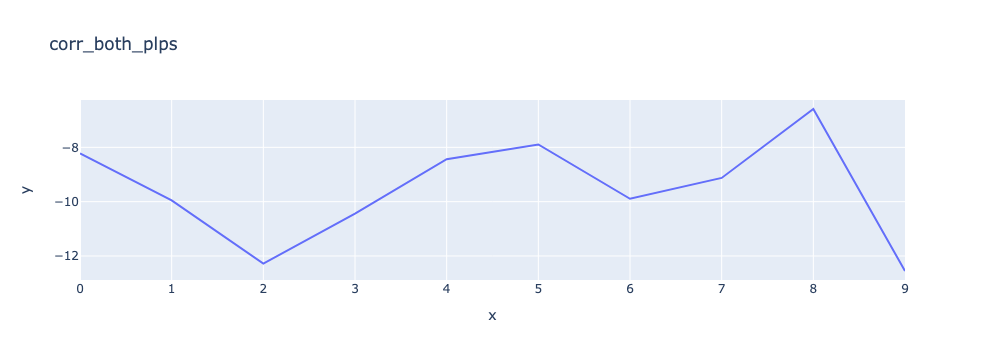

Corr both prompt 0
<|endoftext|>11*7=77
10*5=50
188*132=
Clean Prompt 0
<|endoftext|>11*7=77
10*5=50
19*16=
Corr both Answer 0
320


In [37]:
corr_both_answer = torch.tensor([model.to_single_token(str(i.item() + j.item())) for i, j in zip(corr_x, corr_y)]).to(device)
corr_both_tokens = tokens_filt.clone()
Y_POSITION = -2
corr_both_tokens[:, X_POSITION] = corr_x_index
corr_both_tokens[:, Y_POSITION] = corr_y_index

corr_both_logits, corr_both_cache = model.run_with_cache(corr_both_tokens)
corr_both_log_probs = corr_both_logits.log_softmax(dim=-1)
corr_both_plps = (corr_both_log_probs[torch.arange(num_prompts_filt).to(device), -1, corr_both_answer])
line(corr_both_plps, title="corr_both_plps")

print("Corr both prompt 0")
print(model.to_string(corr_both_tokens[0]))
print("Clean Prompt 0")
print(model.to_string(clean_tokens[0]))
print("Corr both Answer 0")
print(model.to_string(corr_both_answer[0]))

## Residual Stream Patching

In [38]:
def metric(patched_logits, per_token=False):
    patched_log_probs = patched_logits[:, -1, :].float().log_softmax(dim=-1)
    batch = len(patched_log_probs)
    plps = -patched_log_probs[torch.arange(batch, device=device), answer_tokens_filt]
    if per_token:
        return plps
    else:
        return plps.mean()
    
    
    
clean_baseline = (metric(clean_logits))
print("clean_baseline", clean_baseline)
corr_x_baseline = (metric(corr_x_logits))
print("corr_x_baseline", corr_x_baseline)
corr_y_baseline = (metric(corr_y_logits))
print("corr_y_baseline", corr_y_baseline)
corr_both_baseline = (metric(corr_both_logits))
print("corr_both_baseline", corr_both_baseline)

clean_baseline tensor(0.1296)
corr_x_baseline tensor(9.4815)
corr_y_baseline tensor(8.7663)
corr_both_baseline tensor(8.1695)


In [42]:
POS_LABELS = ["X", "+", "Y", "="]
n_layers = model.cfg.n_layers

def resid_patch_hook(resid_pre, hook, pos, layer):
    resid_pre[:, pos, :] = clean_cache["resid_pre", layer][:, pos, :]
    return resid_pre


In [ ]:
corr_x_resid_patching = torch.zeros((4, n_layers)).to(device)
for pos in range(-4, 0):
    for layer in range(n_layers):
        patched_logits = model.run_with_hooks(corr_x_tokens, fwd_hooks = [(
            utils.get_act_name("resid_pre", layer),
            partial(resid_patch_hook, pos=pos, layer=layer),)
        ])
        corr_x_resid_patching[pos, layer] = metric(patched_logits)
        
        
OFFSET_LOG_PROB = 6
imshow((OFFSET_LOG_PROB - corr_x_resid_patching),
       title="corr_x_resid_patching (6 - clean_log_prob)",
       y=POS_LABELS, yaxis="Position",
       xaxis="Layer", zmin=0, 
       zmax=OFFSET_LOG_PROB, color_continuous_scale="Blues")
       

In [ ]:
corr_y_resid_patching = torch.zeros((4, n_layers)).to(device)
for pos in range(-4, 0):
    for layer in range(n_layers):
        patched_logits = model.run_with_hooks(corr_y_tokens, fwd_hooks = [(
            utils.get_act_name("resid_pre", layer),
            partial(resid_patch_hook, pos=pos, layer=layer),)
        ])
        corr_y_resid_patching[pos, layer] = metric(patched_logits)

OFFSET_LOG_PROB = 6
imshow((OFFSET_LOG_PROB - corr_y_resid_patching),
       title="corr_y_resid_patching (6 - clean_log_prob)",
       y=POS_LABELS, yaxis="Position", xaxis="Layer",
       zmin=0, zmax=OFFSET_LOG_PROB, color_continuous_scale="Blues")

In [ ]:
corr_both_resid_patching = torch.zeros((4, n_layers)).cuda()
for pos in range(-4, 0):
    for layer in range(n_layers):
        patched_logits = model.run_with_hooks(corr_both_tokens, fwd_hooks = [(
            utils.get_act_name("resid_pre", layer),
            partial(resid_patch_hook, pos=pos, layer=layer),)
        ])
        corr_both_resid_patching[pos, layer] = metric(patched_logits)

OFFSET_LOG_PROB = 6
imshow((OFFSET_LOG_PROB - corr_both_resid_patching),
       title="corr_both_resid_patching (6 - clean_log_prob)",
       y=POS_LABELS, yaxis="Position", xaxis="Layer",
       zmin=0, zmax=OFFSET_LOG_PROB, color_continuous_scale="Blues")